In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd

TensorFlow 2.x selected.


In [2]:
print(tf.__version__)

2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/sentiment_analysis/movie_data.csv', encoding='utf-8')
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [5]:
df.shape

(50000, 2)

# Clean dataset.

**Removing HTML markup and all non-word characters.**

In [0]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emotions = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emotions).replace('-', ''))
    return text

In [0]:
df['review'] = df['review'].apply(preprocessor)

In [8]:
df.head(3)

,review,sentiment
0,in 1974 the teenager martha moxley maggie grac...,1
1,ok so i really like kris kristofferson and his...,0
2,spoiler do not read this if you think about w...,0


# Processing into tokens, stemming and removing stop words.

In [9]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def stem_and_remove_stop_words(text):
    stop = stopwords.words('english')
    seperator = ' '
    text = seperator.join([w for w in tokenizer_porter(text) if w not in stop])
    return text

In [23]:
df.loc[0, 'review'][:100]

'in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwic'

In [24]:
stem_and_remove_stop_words(df.loc[0, 'review'][:100])

'1974 teenag martha moxley maggi grace move high class area bell greenwic'

In [0]:
df['review'] = df['review'].apply(stem_and_remove_stop_words)

In [26]:
df.head(3)

,review,sentiment
0,1974 teenag martha moxley maggi grace move hig...,1
1,ok realli like kri kristofferson hi usual easi...,0
2,spoiler read thi think watch movi although wou...,0


# Create a dataset.

In [0]:
target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))

In [28]:
# Inspect:
for entry in ds_raw.take(3):
    tf.print(entry[0].numpy()[0][:50], entry[1])

b'1974 teenag martha moxley maggi grace move high cl' 1
b'ok realli like kri kristofferson hi usual easi go ' 0
b'spoiler read thi think watch movi although would w' 0


# Train / validation / test split. 

In [0]:
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(
    50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

# Find unique tokens.

In [41]:
from collections import Counter
import tensorflow_datasets as tfds

tokenizer = tfds.features.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 48694


# Encoding each unique token into integers.

In [0]:
encoder = tfds.features.text.TokenTextEncoder(token_counts)

In [44]:
example_str = 'read watch although'
encoder.encode(example_str)

[453, 324, 571]

# Define the function for transformation.

In [0]:
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

## Step 3-B: wrap the encode function to a TF Op.
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [46]:
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Sequence length:', example[0].shape)
    
example

Sequence length: (13,)
Sequence length: (93,)
Sequence length: (121,)
Sequence length: (306,)
Sequence length: (64,)


(<tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([  980,   579,   444,     3,   361,   114,     2,     3,   518,
          202,   553,  2818,    43,  6616,   201,   271,   250, 10849,
          136,  1226,   377,   104,  2858,  1777,  2607,  1791,  2421,
          800,   424,  5181,  1943,    53,   488,   396,   179,   356,
          728,   431,  3673,    26,     9,   143,   486,   188,  1051,
        10850,   567,     2,   173,   173,   639,   505,   190, 10851,
         7514,   441,   315,   639,   147,   470,  1314,  6102, 10275,
           83])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

# Batching the dataset.

In [0]:
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))

# RNN model.

In [53]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

embedding_dim = 50
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

## build the model
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, name='lstm-layer'),
        name='bidir-lstm'), 

    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

## compile and train:
bi_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

history = bi_lstm_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

## evaluate on the test data
test_results= bi_lstm_model.evaluate(test_data)
print('Test Acc.: {:.2f}%'.format(test_results[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 50)          2434800   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 256)               183296    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,651,121
Trainable params: 2,651,121
Non-trainable params: 0
_________________________________________________________________
Train for 625 steps, validate for 157 steps
Epoch 1/10
625/625 [==============================] - 47s 76ms/step - loss: 0.4448 - accuracy: 0.7915 - val_loss: 0.3042 - val_accuracy: 0.8786
Epoch 2/10
625/625 [==============================] - 

In [0]:
import matplotlib.pyplot as plt
def plot_train_valid(model_history):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    return plt.show()

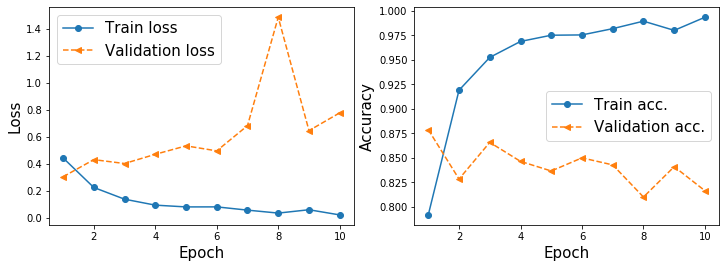

In [55]:
plot_train_valid(history)